In [ ]:
import pandas as pd

datos_inf = pd.read_csv("denuncias_inf.csv")
datos_LEG = pd.read_csv("denuncias_LEG.csv")
datos_LEG["tipo"] = "denuncia-Legal"
datos_LEG['category_id'] = datos_LEG['tipo'].factorize()[0]
datos_LEG

,Unnamed: 0,Denuncias,tipo,category_id
0,0,EN EL 2018 PAGABA A MI VECINO MM POR UN TERREN...,denuncia-Legal,0
1,1,"DENUNCIA REALIZADA POR MMMM, REFIERE QUE EN EL...",denuncia-Legal,0
2,2,DENUNCIA MMMM QUE SU HIJA DE 15 Aï¿½OS DE EDAD...,denuncia-Legal,0
3,3,DENUNCIA REALIZADA POR MMMM SOBRE UN HECHO DE ...,denuncia-Legal,0
4,4,"DENUNCIA REALIZADA POR MMM, OCURRIO UN ACCIDEN...",denuncia-Legal,0
...,...,...,...,...
277,277,Robo denunciado en la ciudad de asuncion un ho...,denuncia-Legal,0
278,278,Robo denunciado en la ciudad de asuncion un ho...,denuncia-Legal,0
279,279,Robo denunciado en la ciudad de asuncion un ho...,denuncia-Legal,0
280,280,Asalto denunciado en la ciudad de asuncion un ...,denuncia-Legal,0


In [ ]:
datos_inf["tipo"] = "denuncia_informatica"
datos_inf["category_id"] = 1
datos_inf
df = pd.concat([datos_LEG,datos_inf])
df = df[df['Denuncias'].notna()]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.es import STOP_WORDS

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=list(STOP_WORDS))

features = tfidf.fit_transform(df.Denuncias).toarray()

features.shape


(505, 622)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

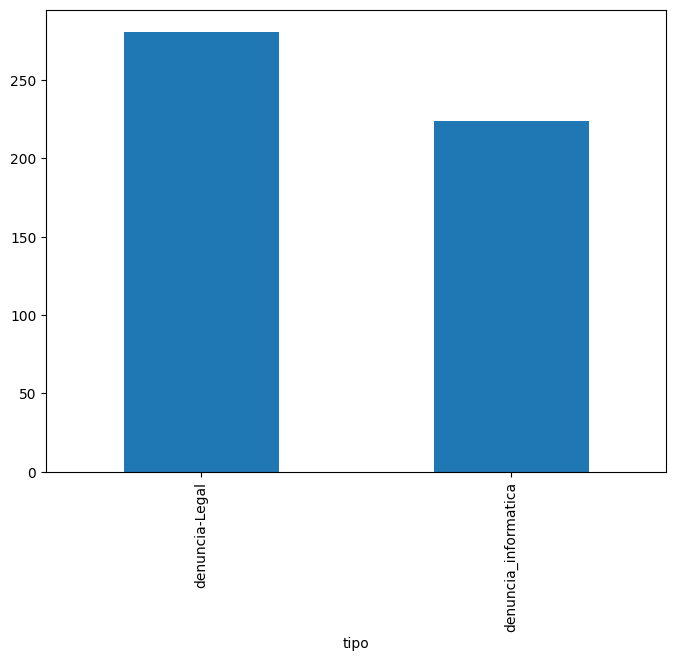

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('tipo').Denuncias.count().plot.bar(ylim=0)
plt

In [ ]:
from io import StringIO
category_id_df = df[['tipo', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'tipo']].values)
labels = df.category_id


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from spacy.lang.es import STOP_WORDS

# Vocabulario personalizado para denuncias legales
legal_tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words=list(STOP_WORDS))
legal_tfidf.fit(df[df['tipo'] == 'denuncia-Legal']['Denuncias'])
legal_vocab = legal_tfidf.vocabulary_

# Vocabulario personalizado para denuncias informáticas
informatica_tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words=list(STOP_WORDS))
informatica_tfidf.fit(df[df['tipo'] == 'denuncia_informatica']['Denuncias'])
informatica_vocab = informatica_tfidf.vocabulary_

# Matriz de características para denuncias legales
legal_features = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words=list(STOP_WORDS), vocabulary=legal_vocab).fit_transform(df[df['tipo'] == 'denuncia-Legal']['Denuncias'])
legal_labels = labels[df['tipo'] == 'denuncia-Legal']

# Matriz de características para denuncias informáticas
informatica_features = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words=list(STOP_WORDS), vocabulary=informatica_vocab).fit_transform(df[df['tipo'] == 'denuncia_informatica']['Denuncias'])
informatica_labels = labels[df['tipo'] == 'denuncia_informatica']

# Calcular chi2 para denuncias legales
legal_chi2 = chi2(legal_features, legal_labels == 0)

# Calcular chi2 para denuncias informáticas
informatica_chi2 = chi2(informatica_features, informatica_labels == 1)

# Función para imprimir los términos más correlacionados
def print_most_correlated_terms(features, labels, n=2):
    features_chi2 = chi2(features, labels)[0]
    indices = np.argsort(features_chi2)[::-1]
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1][:n]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2][:n]
    print(". Most correlated unigrams:\n. {}".format('\n. '.join(unigrams)))
    print(". Most correlated bigrams:\n. {}".format('\n. '.join(bigrams)))

# Imprimir los términos más correlacionados para denuncias legales
print("# 'denuncia-Legal':")
print_most_correlated_terms(legal_features, legal_labels)

# Imprimir los términos más correlacionados para denuncias informáticas
print("# 'denuncia_informatica':")
print_most_correlated_terms(informatica_features, informatica_labels)


# 'denuncia-Legal':
. Most correlated unigrams:
. desconocidas
. aplicaciï
. Most correlated bigrams:
. asaltado delincuente
. aplicaciï ½n
# 'denuncia_informatica':
. Most correlated unigrams:
. pagos
. computadora
. Most correlated bigrams:
. codigos tenia
. compaã ia


# Entrenamiento del modelo para el aprendizaje automatico

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Denuncias'], df['tipo'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
import pandas as pd

# Crear una lista de denuncias
Denuncias = ["Un grupo de usuarios de una red social denunció que sus datos personales fueron filtrados debido a una falla de seguridad en la plataforma.",    "Una empresa de comercio electrónico denunció que fue víctima de un ataque cibernético que comprometió la seguridad de los datos de sus clientes.",    "Un ciudadano denunció que su cuenta bancaria fue hackeada y que el atacante realizó varias transacciones fraudulentas en su nombre.",    "Un trabajador de una empresa de tecnología denunció que la compañía no tomó medidas adecuadas para proteger la información personal de los usuarios.",    "Una organización de derechos digitales denunció que un proveedor de servicios de internet estaba monitoreando ilegalmente el tráfico en línea de sus usuarios.",    "Un grupo de consumidores presentó una denuncia ante una agencia de protección de datos por la recolección y uso ilegal de información personal por parte de una aplicación de salud.",    "Un ciudadano denunció que un sitio web de compras en línea le vendió un producto falso y que su información personal fue utilizada sin su consentimiento.",    "Una empresa de tecnología denunció que un competidor había robado su propiedad intelectual y estaba utilizando su tecnología sin permiso.",    "Un periodista denunció que su correo electrónico fue hackeado y que el atacante había accedido a información confidencial.",    "Un grupo de usuarios de una aplicación de mensajería denunció que sus conversaciones privadas estaban siendo monitoreadas y analizadas por la empresa sin su consentimiento." ,"Un vecino denunció a su comunidad de vecinos por incumplir las normas de convivencia y perturbar el descanso de los demás vecinos.",    "Un grupo de trabajadores presentó una denuncia contra su empresa por no cumplir con las medidas de seguridad necesarias para prevenir accidentes laborales.",    "Un ciudadano presentó una demanda contra el ayuntamiento por negligencia en el mantenimiento de las calles, lo que provocó un accidente de tráfico.",    "Un grupo de mujeres presentó una denuncia contra una empresa por discriminación de género en la selección de personal.",    "Un cliente presentó una denuncia contra una tienda de electrónica por venderle un producto defectuoso y negarse a hacerse responsable.",    "Un grupo de vecinos presentó una denuncia contra una empresa por contaminar el aire y provocar problemas respiratorios en la población.",    "Un trabajador presentó una denuncia contra su jefe por acoso laboral y discriminación.",    "Un ciudadano presentó una demanda contra una aerolínea por cancelar su vuelo sin previo aviso y no ofrecer una alternativa adecuada.",    "Un grupo de usuarios de redes sociales presentó una denuncia contra una plataforma por violar su privacidad y compartir sus datos sin consentimiento.",    "Un ciudadano presentó una denuncia contra una cadena de supermercados por vender productos caducados y en mal estado."]
# Crear un DataFrame para almacenar las denuncias y las predicciones
resultados = pd.DataFrame(columns=['Denuncia', 'Prediccion'])

# Iterar sobre cada denuncia y hacer la predicción
for denuncia in Denuncias:
    # Realizar la predicción utilizando el modelo
    prediccion = clf.predict(count_vect.transform([denuncia]))[0]

    # Agregar la denuncia y la predicción al DataFrame de resultados
    resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)

# Guardar los resultados en un archivo Excel
resultados.to_excel('resultados_predicciones.xlsx', index=False)
print("hi")

<ipython-input-8-5afc0ce4d0ee>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)
<ipython-input-8-5afc0ce4d0ee>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)
<ipython-input-8-5afc0ce4d0ee>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)
<ipython-input-8-5afc0ce4d0ee>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resulta

hi


In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['Denuncias'], df['tipo'], random_state=0)

# Crear el vectorizador de conteo
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

# Aplicar la transformación TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Crear y entrenar el modelo RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_tfidf, y_train)

# Crear una lista de denuncias
Denuncias = ["Un grupo de usuarios de una red social denunció que sus datos personales fueron filtrados debido a una falla de seguridad en la plataforma.",    "Una empresa de comercio electrónico denunció que fue víctima de un ataque cibernético que comprometió la seguridad de los datos de sus clientes.",    "Un ciudadano denunció que su cuenta bancaria fue hackeada y que el atacante realizó varias transacciones fraudulentas en su nombre.",    "Un trabajador de una empresa de tecnología denunció que la compañía no tomó medidas adecuadas para proteger la información personal de los usuarios.",    "Una organización de derechos digitales denunció que un proveedor de servicios de internet estaba monitoreando ilegalmente el tráfico en línea de sus usuarios.",    "Un grupo de consumidores presentó una denuncia ante una agencia de protección de datos por la recolección y uso ilegal de información personal por parte de una aplicación de salud.",    "Un ciudadano denunció que un sitio web de compras en línea le vendió un producto falso y que su información personal fue utilizada sin su consentimiento.",    "Una empresa de tecnología denunció que un competidor había robado su propiedad intelectual y estaba utilizando su tecnología sin permiso.",    "Un periodista denunció que su correo electrónico fue hackeado y que el atacante había accedido a información confidencial.",    "Un grupo de usuarios de una aplicación de mensajería denunció que sus conversaciones privadas estaban siendo monitoreadas y analizadas por la empresa sin su consentimiento." ,"Un vecino denunció a su comunidad de vecinos por incumplir las normas de convivencia y perturbar el descanso de los demás vecinos.",    "Un grupo de trabajadores presentó una denuncia contra su empresa por no cumplir con las medidas de seguridad necesarias para prevenir accidentes laborales.",    "Un ciudadano presentó una demanda contra el ayuntamiento por negligencia en el mantenimiento de las calles, lo que provocó un accidente de tráfico.",    "Un grupo de mujeres presentó una denuncia contra una empresa por discriminación de género en la selección de personal.",    "Un cliente presentó una denuncia contra una tienda de electrónica por venderle un producto defectuoso y negarse a hacerse responsable.",    "Un grupo de vecinos presentó una denuncia contra una empresa por contaminar el aire y provocar problemas respiratorios en la población.",    "Un trabajador presentó una denuncia contra su jefe por acoso laboral y discriminación.",    "Un ciudadano presentó una demanda contra una aerolínea por cancelar su vuelo sin previo aviso y no ofrecer una alternativa adecuada.",    "Un grupo de usuarios de redes sociales presentó una denuncia contra una plataforma por violar su privacidad y compartir sus datos sin consentimiento.",    "Un ciudadano presentó una denuncia contra una cadena de supermercados por vender productos caducados y en mal estado."]

# Crear un DataFrame para almacenar las denuncias y las predicciones
resultados = pd.DataFrame(columns=['Denuncia', 'Prediccion'])

# Iterar sobre cada denuncia y hacer la predicción
for denuncia in Denuncias:
    # Realizar la predicción utilizando el modelo
    prediccion = clf.predict(count_vect.transform([denuncia]))[0]

    # Agregar la denuncia y la predicción al DataFrame de resultados
    resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)

# Guardar los resultados en un archivo Excel
resultados.to_excel('resultados_predicciones_Randomforrest.xlsx', index=False)


<ipython-input-9-eafa82642dd6>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)
<ipython-input-9-eafa82642dd6>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)
<ipython-input-9-eafa82642dd6>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)
<ipython-input-9-eafa82642dd6>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resulta

In [ ]:

# # Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(df['Denuncias'], df['tipo'], random_state=0)

# # Vectorizar los datos de texto
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# # Entrenar el modelo de regresión logística
# clf = LogisticRegression(random_state=0).fit(X_train_tfidf, y_train)

# # Crear una lista de denuncias
# Denuncias = ["Un grupo de usuarios de una red social denunció que sus datos personales fueron filtrados debido a una falla de seguridad en la plataforma.",    "Una empresa de comercio electrónico denunció que fue víctima de un ataque cibernético que comprometió la seguridad de los datos de sus clientes.",    "Un ciudadano denunció que su cuenta bancaria fue hackeada y que el atacante realizó varias transacciones fraudulentas en su nombre.",    "Un trabajador de una empresa de tecnología denunció que la compañía no tomó medidas adecuadas para proteger la información personal de los usuarios.",    "Una organización de derechos digitales denunció que un proveedor de servicios de internet estaba monitoreando ilegalmente el tráfico en línea de sus usuarios.",    "Un grupo de consumidores presentó una denuncia ante una agencia de protección de datos por la recolección y uso ilegal de información personal por parte de una aplicación de salud.",    "Un ciudadano denunció que un sitio web de compras en línea le vendió un producto falso y que su información personal fue utilizada sin su consentimiento.",    "Una empresa de tecnología denunció que un competidor había robado su propiedad intelectual y estaba utilizando su tecnología sin permiso.",    "Un periodista denunció que su correo electrónico fue hackeado y que el atacante había accedido a información confidencial.",    "Un grupo de usuarios de una aplicación de mensajería denunció que sus conversaciones privadas estaban siendo monitoreadas y analizadas por la empresa sin su consentimiento." ,"Un vecino denunció a su comunidad de vecinos por incumplir las normas de convivencia y perturbar el descanso de los demás vecinos.",    "Un grupo de trabajadores presentó una denuncia contra su empresa por no cumplir con las medidas de seguridad necesarias para prevenir accidentes laborales.",    "Un ciudadano presentó una demanda contra el ayuntamiento por negligencia en el mantenimiento de las calles, lo que provocó un accidente de tráfico.",    "Un grupo de mujeres presentó una denuncia contra una empresa por discriminación de género en la selección de personal.",    "Un cliente presentó una denuncia contra una tienda de electrónica por venderle un producto defectuoso y negarse a hacerse responsable.",    "Un grupo de vecinos presentó una denuncia contra una empresa por contaminar el aire y provocar problemas respiratorios en la población.",    "Un trabajador presentó una denuncia contra su jefe por acoso laboral y discriminación.",    "Un ciudadano presentó una demanda contra una aerolínea por cancelar su vuelo sin previo aviso y no ofrecer una alternativa adecuada.",    "Un grupo de usuarios de redes sociales presentó una denuncia contra una plataforma por violar su privacidad y compartir sus datos sin consentimiento.",    "Un ciudadano presentó una denuncia contra una cadena de supermercados por vender productos caducados y en mal estado."]

# # Crear un DataFrame para almacenar las denuncias y las predicciones
# resultados = pd.DataFrame(columns=['Denuncia', 'Prediccion'])

# # Iterar sobre cada denuncia y hacer la predicción
# for denuncia in Denuncias:
#     # Realizar la predicción utilizando el modelo
#     prediccion = clf.predict(count_vect.transform([denuncia]))[0]

#     # Agregar la denuncia y la predicción al DataFrame de resultados
#     resultados = resultados.append({'Denuncia': denuncia, 'Prediccion': prediccion}, ignore_index=True)

# # Guardar los resultados en un archivo Excel
# resultados.to_excel('resultados_predicciones_LogisticRegression.xlsx', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.901961
1,RandomForestClassifier,1,0.941176
2,RandomForestClassifier,2,0.960784
3,RandomForestClassifier,3,0.941176
4,RandomForestClassifier,4,0.921569
5,RandomForestClassifier,5,0.840000
6,RandomForestClassifier,6,0.740000
7,RandomForestClassifier,7,0.560000
8,RandomForestClassifier,8,0.560000
9,RandomForestClassifier,9,0.560000


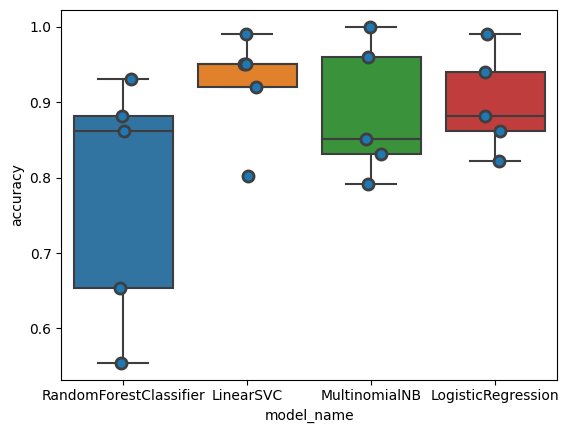

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.922772
LogisticRegression        0.899010
MultinomialNB             0.887129
RandomForestClassifier    0.776238
Name: accuracy, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

#Aqui hay que pasarle los legal features, y los inf features y lo mismo con los labels
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

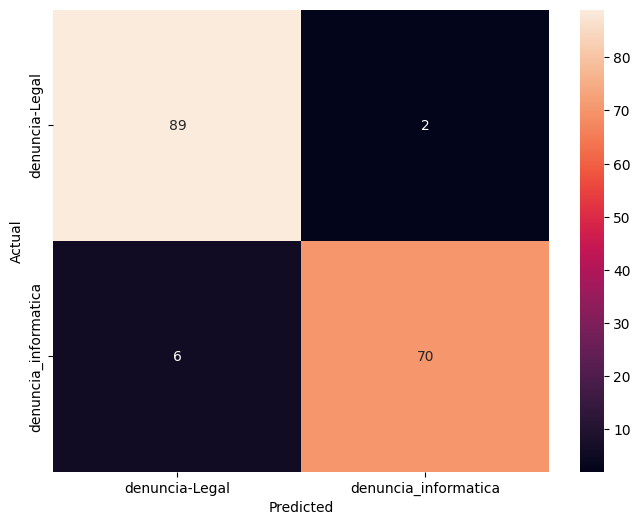

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.tipo.values, yticklabels=category_id_df.tipo.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['tipo', 'Denuncias']])
      print('')

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['tipo', 'Denuncias']])
      print('')

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                    target_names=df['tipo'].unique()))

### Creamos un Dataset con los resultados que nos vaya arrojando nuestro modelo.

In [ ]:
import pandas as pd

# Datos de entrada
texts = [    "Un grupo de usuarios de una red social denunció que sus datos personales fueron filtrados debido a una falla de seguridad en la plataforma.",    "Una empresa de comercio electrónico denunció que fue víctima de un ataque cibernético que comprometió la seguridad de los datos de sus clientes.",    "Un ciudadano denunció que su cuenta bancaria fue hackeada y que el atacante realizó varias transacciones fraudulentas en su nombre.",    "Un trabajador de una empresa de tecnología denunció que la compañía no tomó medidas adecuadas para proteger la información personal de los usuarios.",    "Una organización de derechos digitales denunció que un proveedor de servicios de internet estaba monitoreando ilegalmente el tráfico en línea de sus usuarios.",    "Un grupo de consumidores presentó una denuncia ante una agencia de protección de datos por la recolección y uso ilegal de información personal por parte de una aplicación de salud.",    "Un ciudadano denunció que un sitio web de compras en línea le vendió un producto falso y que su información personal fue utilizada sin su consentimiento.",    "Una empresa de tecnología denunció que un competidor había robado su propiedad intelectual y estaba utilizando su tecnología sin permiso.",    "Un periodista denunció que su correo electrónico fue hackeado y que el atacante había accedido a información confidencial.",    "Un grupo de usuarios de una aplicación de mensajería denunció que sus conversaciones privadas estaban siendo monitoreadas y analizadas por la empresa sin su consentimiento." ,"Un vecino denunció a su comunidad de vecinos por incumplir las normas de convivencia y perturbar el descanso de los demás vecinos.",    "Un grupo de trabajadores presentó una denuncia contra su empresa por no cumplir con las medidas de seguridad necesarias para prevenir accidentes laborales.",    "Un ciudadano presentó una demanda contra el ayuntamiento por negligencia en el mantenimiento de las calles, lo que provocó un accidente de tráfico.",    "Un grupo de mujeres presentó una denuncia contra una empresa por discriminación de género en la selección de personal.",    "Un cliente presentó una denuncia contra una tienda de electrónica por venderle un producto defectuoso y negarse a hacerse responsable.",    "Un grupo de vecinos presentó una denuncia contra una empresa por contaminar el aire y provocar problemas respiratorios en la población.",    "Un trabajador presentó una denuncia contra su jefe por acoso laboral y discriminación.",    "Un ciudadano presentó una demanda contra una aerolínea por cancelar su vuelo sin previo aviso y no ofrecer una alternativa adecuada.",    "Un grupo de usuarios de redes sociales presentó una denuncia contra una plataforma por violar su privacidad y compartir sus datos sin consentimiento.",    "Un ciudadano presentó una denuncia contra una cadena de supermercados por vender productos caducados y en mal estado."]


# Predecir las categorías
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

# Crear listas para cada columna del DataFrame
denuncia_list = []
tipo_list = []

# Llenar las listas con los datos
for text, predicted in zip(texts, predictions):
    denuncia_list.append(text)
    tipo_list.append(id_to_category[predicted])

# Crear el DataFrame
df = pd.DataFrame({'Denuncia': denuncia_list, 'tipo': tipo_list})

# Guardar el DataFrame en un archivo CSV
df.to_excel('denuncias.xlsx')

df

In [ ]:
import pandas as pd

text = 'Un robo en una vivienda de asuncion, entraron dos delincuentes y se llevaron objetos de valor'

text_features = tfidf.transform(text)
predictions = model.predict(text_features)

print(predictions)

ValueError: ignored

# End of tesis

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random
from datetime import date, datetime

In [ ]:
zillow = "https://www.zillow.com/redding-ca/fsbo/?searchQueryState=%7B%22usersSearchTerm%22%3A%22Redding%2C%20CA%22%2C%22mapBounds%22%3A%7B%22west%22%3A-122.64684715332031%2C%22east%22%3A-121.97530784667968%2C%22south%22%3A40.42663065068017%2C%22north%22%3A40.861148566020944%7D%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A47322%2C%22regionType%22%3A6%7D%5D%2C%22isMapVisible%22%3Afalse%2C%22category%22%3A%22cat2%22%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A11%7D"


In [ ]:
headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.8',
        'cache-control': 'no-cache',
        "cookie":'zguid=24|$7f42baba-788a-454e-acd8-c7e70f6bcd0a; zgsession=1|07ad1397-f7a6-4531-a105-d4bca175efea; _ga=GA1.2.223205435.1670447769; zjs_user_id=null; zg_anonymous_id="f81804b7-21eb-436f-bad0-f01b703651c1"; zjs_anonymous_id="7f42baba-788a-454e-acd8-c7e70f6bcd0a"; pxcts=5e493448-7674-11ed-b2dc-644241697947; _pxvid=5e4921bb-7674-11ed-b2dc-644241697947; _gcl_au=1.1.526233822.1670447769; DoubleClickSession=true; _cs_c=0; utag_main=v_id:0184ee72268b006125c4b5717eb005075001706d00bd0$_sn:1$_se:1$_ss:1$_st:1670449569228$ses_id:1670447769228;exp-session$_pn:1;exp-session$dcsyncran:1;exp-session$tdsyncran:1;exp-session$dc_visit:1$dc_event:1;exp-session$dc_region:us-west-2;exp-session; __pdst=09ff59cdf472426eacb1952bcb738760; _fbp=fb.1.1670447770893.1427663025; _pin_unauth=dWlkPU4yUmlPR05tTW1NdFpqTmtPQzAwTVRCbExXRmxNVFl0WWpsallUTXhObU5qTURSbQ; __gads=ID=d928549d0d10c8e9:T=1670447789:S=ALNI_MZ2vCJ2ydoGKLwyiyQYWMmyMCEYJQ; _clck=1qbb1tk|1|f7c|0; _gid=GA1.2.1791235879.1670882459; KruxPixel=true; _hp2_ses_props.1215457233={"ts":1670882460214,"d":"www.zillow.com","h":"/"}; JSESSIONID=B88E7D43186DA90EE0DE5F8DA7AACC79; __gpi=UID=0000090d94d3217f:T=1670447789:RT=1670882470:S=ALNI_MaAipz_xEdVRpITS8FF3nykzhwmoQ; KruxAddition=true; _cs_id=a94aef50-32ce-a2eb-9bc6-a30e415f9d22.1670447769.2.1670882869.1670882460.1.1704611769485; _cs_s=2.5.0.1670884669842; _hp2_id.1215457233={"userId":"8071024779595274","pageviewId":"163331852153630","sessionId":"6773580954950247","identity":null,"trackerVersion":"4.0"}; _px3=d7187c16d3b4aa8e6a17c41fd3c7a5b01734926532028f17f4d634859aeba7fa:dUo86PtbNlNKA8CZqLHYaoXgh8ycBIjgE9SPY4Cik8ptyERaZb2wmlvQx86ZWq4RXRqf9W2XnMPML2zorVfU8Q==:1000:fVEHHukaM2fXQlbQ7Vgi7fmbR8b7+Az/0OH6IafLOJBgN7Nm4QWTZFGBJvTbUMo9tlP5Th/oUV2NTPep5G6H8DYBq5FXNEuwJlD2I7Ua+RLl01AwAY12KgHGMfqnAo/5AKhS4oSCizJNnEIW04hByD7kcbhyjwJVhSOaIY4+e90W2FqwkfD7qRkI1271cG+KFSxJItlwJHMOP5OW9ZNeBw==; _uetsid=77596cd07a6811eda4312d337bb09dfe; _uetvid=5f656990767411edbbd27b674a5aa2f4; _gat=1; AWSALB=Xn+HEaMwzpjce9C0eM27aLDTttvXqk1xmaOaQzeLWyndx8vXSE9sl1B65prYLU+Hd7B8hMMVXixgBvD1rQPOu/OZppgEgTJdGIDR05QI+u6gmeguex1fD5iSpw5x; AWSALBCORS=Xn+HEaMwzpjce9C0eM27aLDTttvXqk1xmaOaQzeLWyndx8vXSE9sl1B65prYLU+Hd7B8hMMVXixgBvD1rQPOu/OZppgEgTJdGIDR05QI+u6gmeguex1fD5iSpw5x; search=6|1673475124255|rect=39.04111161492053%2C-121.19050515136719%2C38.174031858212814%2C-121.74119484863282&rid=20288&disp=map&mdm=auto&p=1&z=1&lt=fsbo&fs=1&fr=0&mmm=0&rs=0&ah=0&singlestory=0&housing-connector=0&abo=0&garage=0&pool=0&ac=0&waterfront=0&finished=0&unfinished=0&cityview=0&mountainview=0&parkview=0&waterview=0&hoadata=1&zillow-owned=0&3dhome=0&featuredMultiFamilyBuilding=0&commuteMode=driving&commuteTimeOfDay=now		20288						; _clsk=1ufr8i|1670883124606|37|0|e.clarity.ms/collect',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'}

In [ ]:
params ={"searchQueryState":'{"usersSearchTerm":"Redding, CA","mapBounds":{"west":-122.64684715332031,"east":-121.97530784667968,"south":40.42663065068017,"north":40.861148566020944},"regionSelection":[{"regionId":47322,"regionType":6}],"isMapVisible":false,"category":"cat2","filterState":{"sort":{"value":"globalrelevanceex"},"ah":{"value":true},"fore":{"value":false},"fsba":{"value":false},"nc":{"value":false},"cmsn":{"value":false},"auc":{"value":false}},"isListVisible":true,"mapZoom":11}'}


In [ ]:
response = requests.get(zillow, headers=headers, params = params)

In [ ]:
response.status_code

200

In [ ]:
encod = response.encoding
contents = response.content.decode(encod)

In [ ]:
soup = BeautifulSoup(contents, 'html.parser') #this line here contain all the html code

In [ ]:
#Print out the title of the pages
titles = soup.title.text
print(titles)

Redding CA For Sale by Owner (FSBO) - 7 Homes | Zillow


In [ ]:
time.sleep(random.uniform(15, 119)) # wait untill page loads completely #2022
today = date.today().strftime("%m/%d/%y")
table1 = pd.DataFrame(columns = ["Address", "Price", "Link", "Posted_Time", "Detail"])

houses = soup.find_all("article", {"class": "StyledPropertyCard-c11n-8-73-8__sc-jvwq6q-0 gHGLmX srp__sc-15y3msw-0 epgJFL property-card list-card_not-saved"})

for house in houses:
    try:
        address = house.find("address", {"data-test":"property-card-addr"}).text
        price = house.find("span", {"data-test":"property-card-price" }).text
        link = house.find("div", {"class":"StyledPropertyCardDataWrapper-c11n-8-73-8__sc-1omp4c3-0 gXNuqr property-card-data" }).a["href"]
        posted = house.find("div", class_ = "StyledPropertyCardBadgeArea-c11n-8-73-8__sc-wncxdw-0 hlsElW").text + " From " + str(today)
        detail = house.find("span", {"class":"StyledPropertyCardHomeDetails-c11n-8-73-8__sc-1mlc4v9-0 jlVIIO" }).text
    except Exception as e:
        address = None
        price = None
        link = None
        posted = None
        detail = None


    table1 = table1.append({"Address": address, "Price": price, "Link": link,
                            "Posted_Time": posted, "Detail": detail }, ignore_index=True)

table1

,Address,Price,Link,Posted_Time,Detail


In [ ]:
table1 = pd.DataFrame(columns = ["Address", "Price", "Detail", "Link", "Posted_Time"])
houses = soup.find_all("article", {"class": "list-card list-card-additional-attribution list-card_not-saved"})

for house in houses:
    try:
        time.sleep(random.uniform(15, 60)) # wait untill page loads completely
        address = house.find("address", {"class":"list-card-addr" }).text
        link = house.find("div", {"class":"list-card-info" }).a["href"]
        price = house.find("div", {"class":"list-card-price" }).text
        detail = house.find("ul", {"class":"list-card-details" }).text
        posted = house.find("div", class_ = "list-card-variable-text list-card-img-overlay").text + " From " + str(today)

    except Exception as e:
        address = None
        link = None
        price = None
        detail = None
        posted = None


    table1 = table1.append({"Address": address, "Price": price,
                            "Detail": detail, "Link": link, "Posted_Time": posted}, ignore_index=True)

table1

,Address,Price,Detail,Link,Posted_Time


In [ ]:
city = ["Redding", "Anderson", "Cottonwood", "Red-Bluff", "Corning", "Orland" ]
first_part = "https://www.zillow.com/homes/"
last_part = ",-CA_rb/"
urls = []
for i in city:
    urls.append(first_part + i + last_part)
urls

['https://www.zillow.com/homes/Redding,-CA_rb/',
 'https://www.zillow.com/homes/Anderson,-CA_rb/',
 'https://www.zillow.com/homes/Cottonwood,-CA_rb/',
 'https://www.zillow.com/homes/Red-Bluff,-CA_rb/',
 'https://www.zillow.com/homes/Corning,-CA_rb/',
 'https://www.zillow.com/homes/Orland,-CA_rb/']

In [ ]:
time.sleep(8)
def city_scraping(u):
    header = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36" }
    response = requests.get(u, headers = header )
    soup = BeautifulSoup(response.content, 'html.parser')
    #Search for data and store them in a table
    table = pd.DataFrame(columns = ["Address", "Price", "Detail", "Links"])
    #print(soup.prettify())

    houses = soup.find_all("div", class_ = "list-card-info")

    for house in houses:
        try:
            address = house.find("address", {"class":"list-card-addr" }).text
            price = house.find("div", {"class":"list-card-price" }).text.split("$")[1].replace(",","") #split to take price only, not $ sign
            detail = house.find("ul", {"class":"list-card-details" }).text
            link = house.a["href"]
        except Exception as e:
            address = None
            link = None
            detail = None
            price = None


        table = table.append({"Address": address, "Price": price,
                                "Detail": detail, "Links":link}, ignore_index=True)
    return table

In [ ]:
urls[0]

'https://www.zillow.com/homes/Redding,-CA_rb/'

In [ ]:
time.sleep(30)
redding = city_scraping(urls[0])
redding

0


,Address,Price,Detail,Links


In [ ]:
time.sleep(30)
anderson = city_scraping(urls[1])
anderson

,Address,Price,Detail,Links


In [ ]:
time.sleep(30)
cottonwood = city_scraping(urls[2])
cottonwood

In [ ]:
time.sleep(30)
red_bluff = city_scraping(urls[3])
red_bluff

KeyboardInterrupt: ignored

In [ ]:
time.sleep(35)
corning = city_scraping(urls[4])
corning